# Entrainer les agents addi

## Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
%cd /content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/

/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler


In [3]:
import Euler.core_solver as core
import Euler.agent_addi as aga
import Euler.neural_networks as nn

from Euler.backend import K
from Euler.param import Param,Projecter
from Euler.initial_conditions import GenParam,FuncGenerator

#from Euler.backend import K
import matplotlib.pyplot as plt
import popup_lib.popup as pop
import numpy as np
import copy
import time

Popup loaded!


In [4]:
order = 1
nx = 1200 // order
if order == 1:
  nx = 600
nx_ratio = nx // 100

param = Param(nx=nx,batch_size=64,nx_ratio=nx_ratio,
              BC_solver=Param.BC_periodic,
              BC_model=Param.BC_periodic)

k_tf32=K("tf",32)

genParam=GenParam(param,kind=GenParam.kind_changing)
genParam.continuousPart_scale = 0.5
genParam.discontinuousPart_scale =0.5
genParam.sod_scale=0.5
# genParam.initial_speed_factor= 1
genParam.initial_speed_factor= 0
genParam.changing_discountMinSpacing= 0.4
genParam.changing_discountMaxSpacing= 0.8
generator=FuncGenerator(genParam, param, k_tf32)

Param initialised with, nx=600, nx_coarse=99, batch_size=64


In [18]:
fam_size=6
period_duration="60 seconds"
all_agents=[]
# nb_t = 500
# nb_t = 600
# nb_t = 1200
nb_t = 2400 // order
if order == 1: 
  nb_t = 800

W_train, Y_train=core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
W_train.shape

TensorShape([800, 64, 600, 3])

In [19]:
def family_full(window_size,color):
        name="full_"+str(window_size)
        agents=[]
        model_struct = (32,64,32)
        # model_struct = (16,32,16)
        for _ in range(fam_size):
            agent= aga.Agent_addi(param, nn.Difference_model_tricky(param,window_size,model_struct=model_struct),
                            watch_duration=20,
                            lossCoef_stab=10.,
                            lossCoef_ridge=3e-3,
                            lossCoef_disHLL=1.,
                            nb_optimization=15,
                            )
            agents.append(agent)
            all_agents.append(agent)
            
        return pop.Family_trainer(
            agents=agents,
            nb_bestweights_averaged=3,
            nb_strong=3,
            period_duration=period_duration,
            name=name,
            color=color)

family_trainers=[
                 family_full(5,"red"),
                #  family_full(3,"blue"),
                 ]

def load_data():
    # global_count["count"]+=1
    # if global_count["count"]%2==0:
    #     param.BC="periodic"
    # else:
    #     param.BC="neumann"
    nb_t=800
    ti=time.time()
    W_train, Y_train = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
    W_val, Y_val = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
    print("|génération des données: ",time.time()-ti,end="")
    
    ti=time.time()
    for agent in all_agents:
        agent.load_WY_train(W_train, Y_train)
        agent.load_WY_valid(W_val, Y_val)
    print("|load données: ",time.time()-ti,end="")

In [20]:
try:
    for i in range(50):
        load_data()
        for family_trainer in family_trainers:
            family_trainer.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()

|génération des données:  0.006876468658447266|load données:  20.29929828643799
full_5,échauffement Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
a↗-infTraçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
b↗-infTraçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
c↗-infTraçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
d↗-infTraçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
e↗-infTraçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
f↗-inf|génération des données:  0.006553173065185547|load données:  20.02264404296875
full_5,period:1 -----, mutations:a⇇d||génération des données:  0.006280183792114258|load données:  20.3131365776062
full_5,period:2 ---, mutations:a⇇d⇇f||génération des données:  0.006265878677368164|load données:  20.06460165977478
full_5,period:3 ---, mutations:a⇇d⇇f⇇e||génération des données:  0.006691694259643555|load données:  20.27304244041443


### Historique des `famparams`

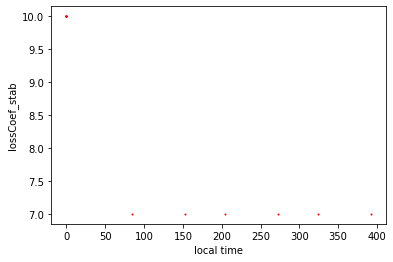

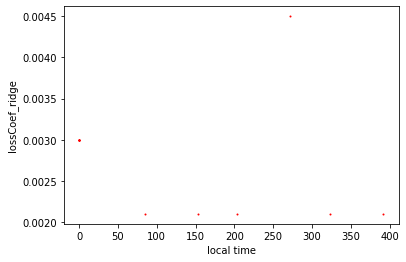

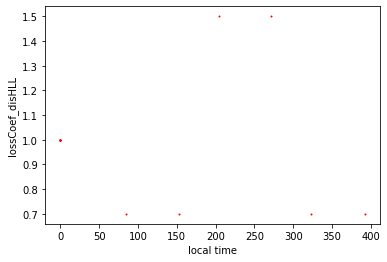

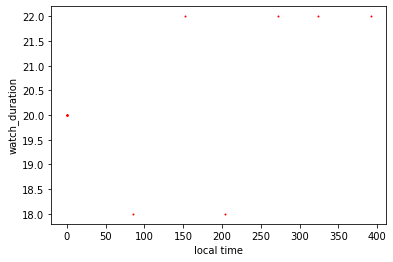

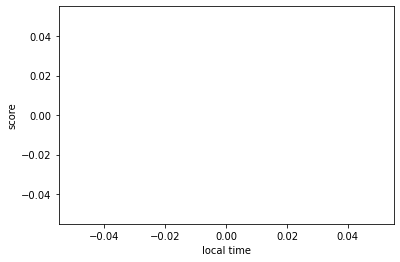

In [8]:
def plot_history_famparams():
    # keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","lossCoef_Laplacian","watch_duration","score"]
    keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","watch_duration","score"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_famparams()

### Historique des trois `loss`

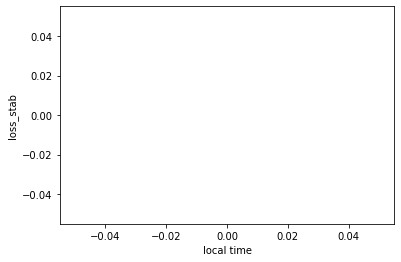

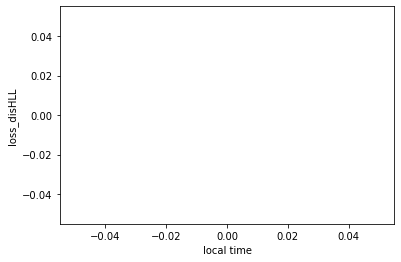

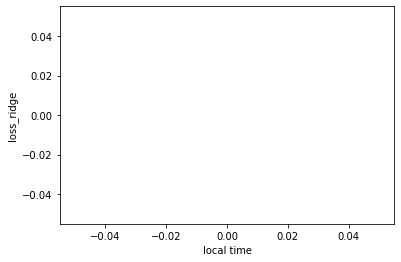

In [9]:
def plot_history_losses():
    # keys=["loss_stab","loss_disHLL","loss_ridge","loss_Laplacian"]
    keys=["loss_stab","loss_disHLL","loss_ridge"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_losses()

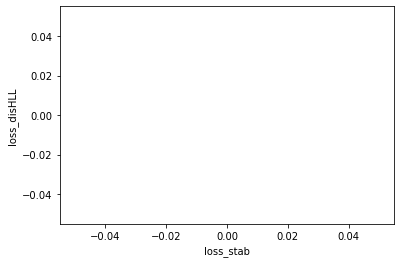

In [10]:
fig,ax=plt.subplots()
for family_trainer in family_trainers:
    family_trainer.plot_two_metrics("loss_stab","loss_disHLL",ax)

## Testons sur le jeu "loop" (périodique)

In [11]:
import tensorflow as tf
family_trainer=family_trainers[0]

for char in ['a', 'b', 'c', 'd', 'e', 'f']:
    best_agent=family_trainer.agents[char].agent
    print(char)
    print(best_agent.famparams)
    print(best_agent.agent_score())

best_agent=family_trainer.get_best_agent()
# best_agent=family_trainer.agents['a'].agent
print("best agent")
print(best_agent.famparams)
# print(best_agent.agent_score())

nb_t = 2400 // order
if order == 1: 
  nb_t = 800


# #attention, modification des paramètres globaux
# genParam.kind=GenParam.kind_loop
# param.BC_solver=param.BC_model=Param.BC_periodic

genParam=GenParam(param,kind=GenParam.kind_changing)
genParam.continuousPart_scale = 0.5
genParam.discontinuousPart_scale =0.5
genParam.sod_scale=0.5
genParam.initial_speed_factor= 0
genParam.changing_discountMinSpacing= 0.4
genParam.changing_discountMaxSpacing= 0.8
generator=FuncGenerator(genParam, param, k_tf32)


a
{'lossCoef_stab': 7.0, 'lossCoef_ridge': 0.0021, 'lossCoef_disHLL': 0.7, 'watch_duration': 22}
nan
b
{'lossCoef_stab': 10.0, 'lossCoef_ridge': 0.003, 'lossCoef_disHLL': 1.0, 'watch_duration': 20}
nan
c
{'lossCoef_stab': 10.0, 'lossCoef_ridge': 0.003, 'lossCoef_disHLL': 1.0, 'watch_duration': 20}
nan
d
{'lossCoef_stab': 10.0, 'lossCoef_ridge': 0.003, 'lossCoef_disHLL': 1.0, 'watch_duration': 20}
nan
e
{'lossCoef_stab': 10.0, 'lossCoef_ridge': 0.003, 'lossCoef_disHLL': 1.0, 'watch_duration': 20}
nan
f
{'lossCoef_stab': 10.0, 'lossCoef_ridge': 0.003, 'lossCoef_disHLL': 1.0, 'watch_duration': 20}
nan
best agent
{'lossCoef_stab': 10.0, 'lossCoef_ridge': 0.003, 'lossCoef_disHLL': 1.0, 'watch_duration': 20}


In [12]:
W_val, Y_val = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
best_agent.load_WY_valid(W_val, Y_val)

## Testons le long du temps

In [13]:
def compare_along_the_time(kind):
    #on garde la BC_reflexive
    if kind==GenParam.kind_sod:
        param.BC_model=param.BC_solver=Param.BC_neumann
    genParam.kind=kind
    generator=FuncGenerator(genParam,param,k_tf32)
    
    model_addi=best_agent.model
    W_init = generator.init_W()

    if kind == "sod" or kind == "random_sod":
        # nb_t = 1500
        nb_t = 2500
    else:
        # nb_t = 500
        nb_t = 1200
    # # nb_t = 600
    nb_t = 1200

    nb_t = 2400 // order
    if order == 1: 
      nb_t = 800

    proj=Projecter(param.nx_ratio,32)
    print(W_init.shape)
    W_init_coarse=proj.projection(W_init)
    
    res_fine,_=core.compute_solutions(param, nb_t, W_init,False,k_tf32)
    res_fine_proj=[proj.projection(res) for res in res_fine]
    res_fine_proj=k_tf32.stack(res_fine_proj)

    res_coarse,_=core.compute_solutions(param, nb_t, W_init_coarse,True,k_tf32)

    res_coarse_model=[None] * nb_t
    w_coarse=W_init_coarse
    for t in range(nb_t):

        var = core.Var(w_coarse, param, k_tf32)
        Fnum_HLL = core.Flux_HLLC(var, param, k_tf32)
        dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

        if "sod" not in kind:
            X = var.get_augmentation()
            addi = model_addi(X)
            dFnum=dFnum_HLL+addi
        else:
            if t >= 0:
                X = var.get_augmentation()
                addi = model_addi(X)
                dFnum=dFnum_HLL+addi
            else:
                dFnum = dFnum_HLL

        w_coarse = w_coarse - param.dt_over_dx_coarse * dFnum
        res_coarse_model[t] = w_coarse

    res_coarse_model=k_tf32.stack(res_coarse_model)

    step=100
    nb_res=nb_t // step

    if kind!="sod":
        fig, ax = plt.subplots(nb_res,5,figsize=(10*2,nb_res*3))
        for i in range(nb_res):
            t=i*step
            for j in range(5):
                ax[i,j].plot(res_fine_proj[t,j,:,0],color="k",label="HLL")
                ax[i,j].plot(res_coarse[t,j,:,0],color="b",label="HLL")
                ax[i,j].plot(res_coarse_model[t,j,:,0],color="r",label="HLL")
        ax[0,0].legend()
    else:
        fig, ax = plt.subplots(nb_res,1,figsize=(10,nb_res*3))
        for i in range(nb_res):
            t=i*step
            ax[i].plot(res_fine_proj[t,0,:,0],color="k",label="HLL")
            ax[i].plot(res_coarse[t,0,:,0],color="b",label="HLL")
            ax[i].plot(res_coarse_model[t,0,:,0],color="r",label="HLL")
        ax[0].legend()    

    fig.tight_layout()
    
    errors_HLL=tf.reduce_mean((res_fine_proj-res_coarse)**2,axis=[1,2,3])
    errors_model=tf.reduce_mean((res_fine_proj-res_coarse_model)**2,axis=[1,2,3])
    
    fig,ax=plt.subplots()
    ax.plot(errors_HLL,label="HLL")
    ax.plot(errors_model,label="model")

    if (np.max(errors_model)>0.1):
        ax.set_ylim(0,0.1)
    
    ax.legend()
    ax.set_xlabel("time")

    plt.show()



### kind Loop

(64, 600, 3)


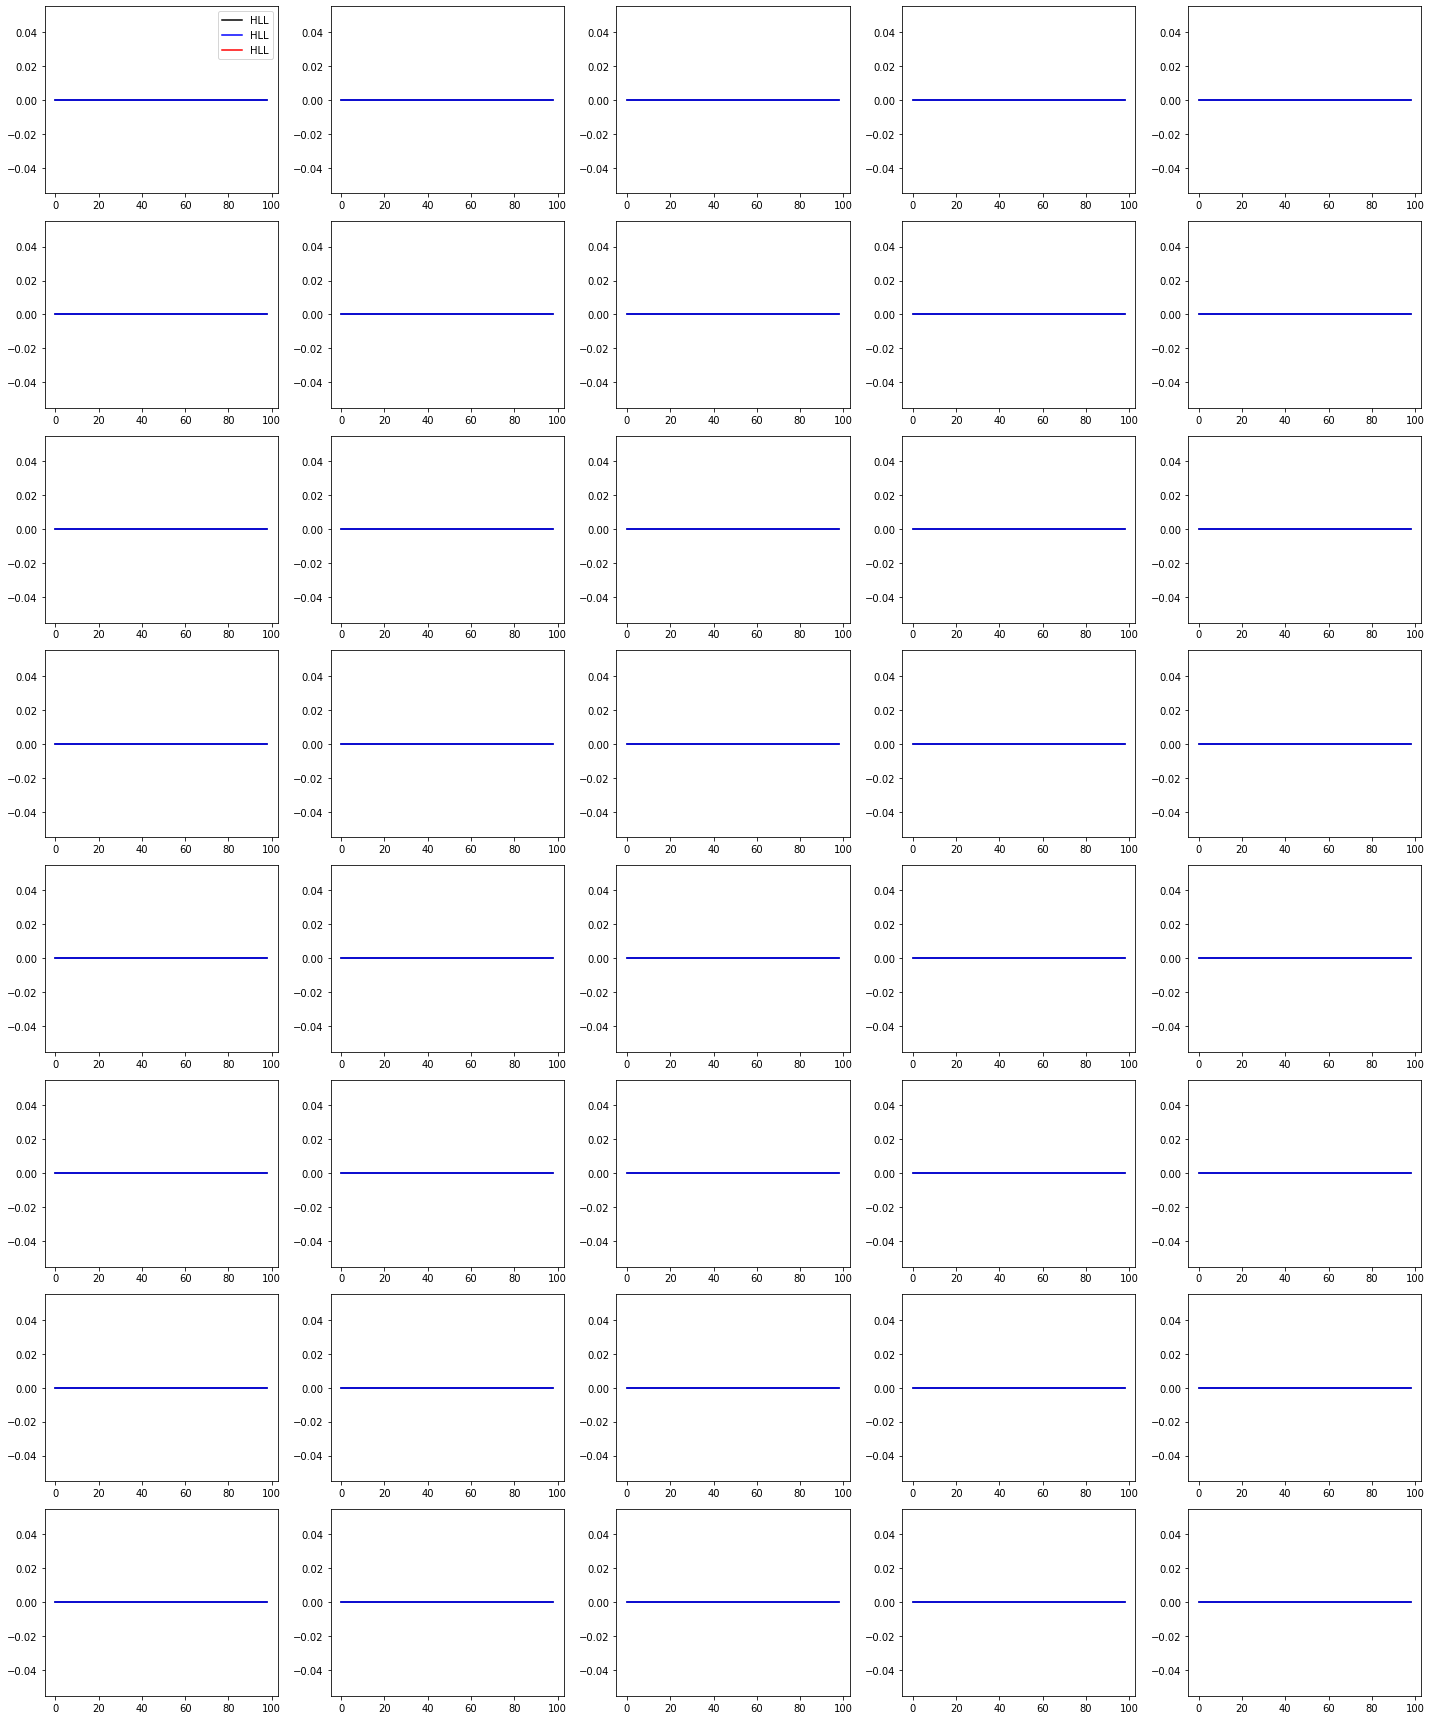

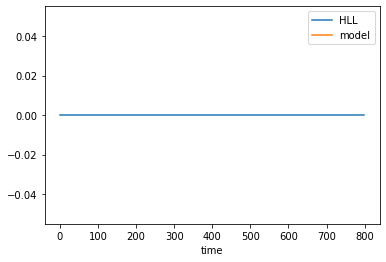

In [14]:
compare_along_the_time(GenParam.kind_loop)

### kind changing

(64, 600, 3)


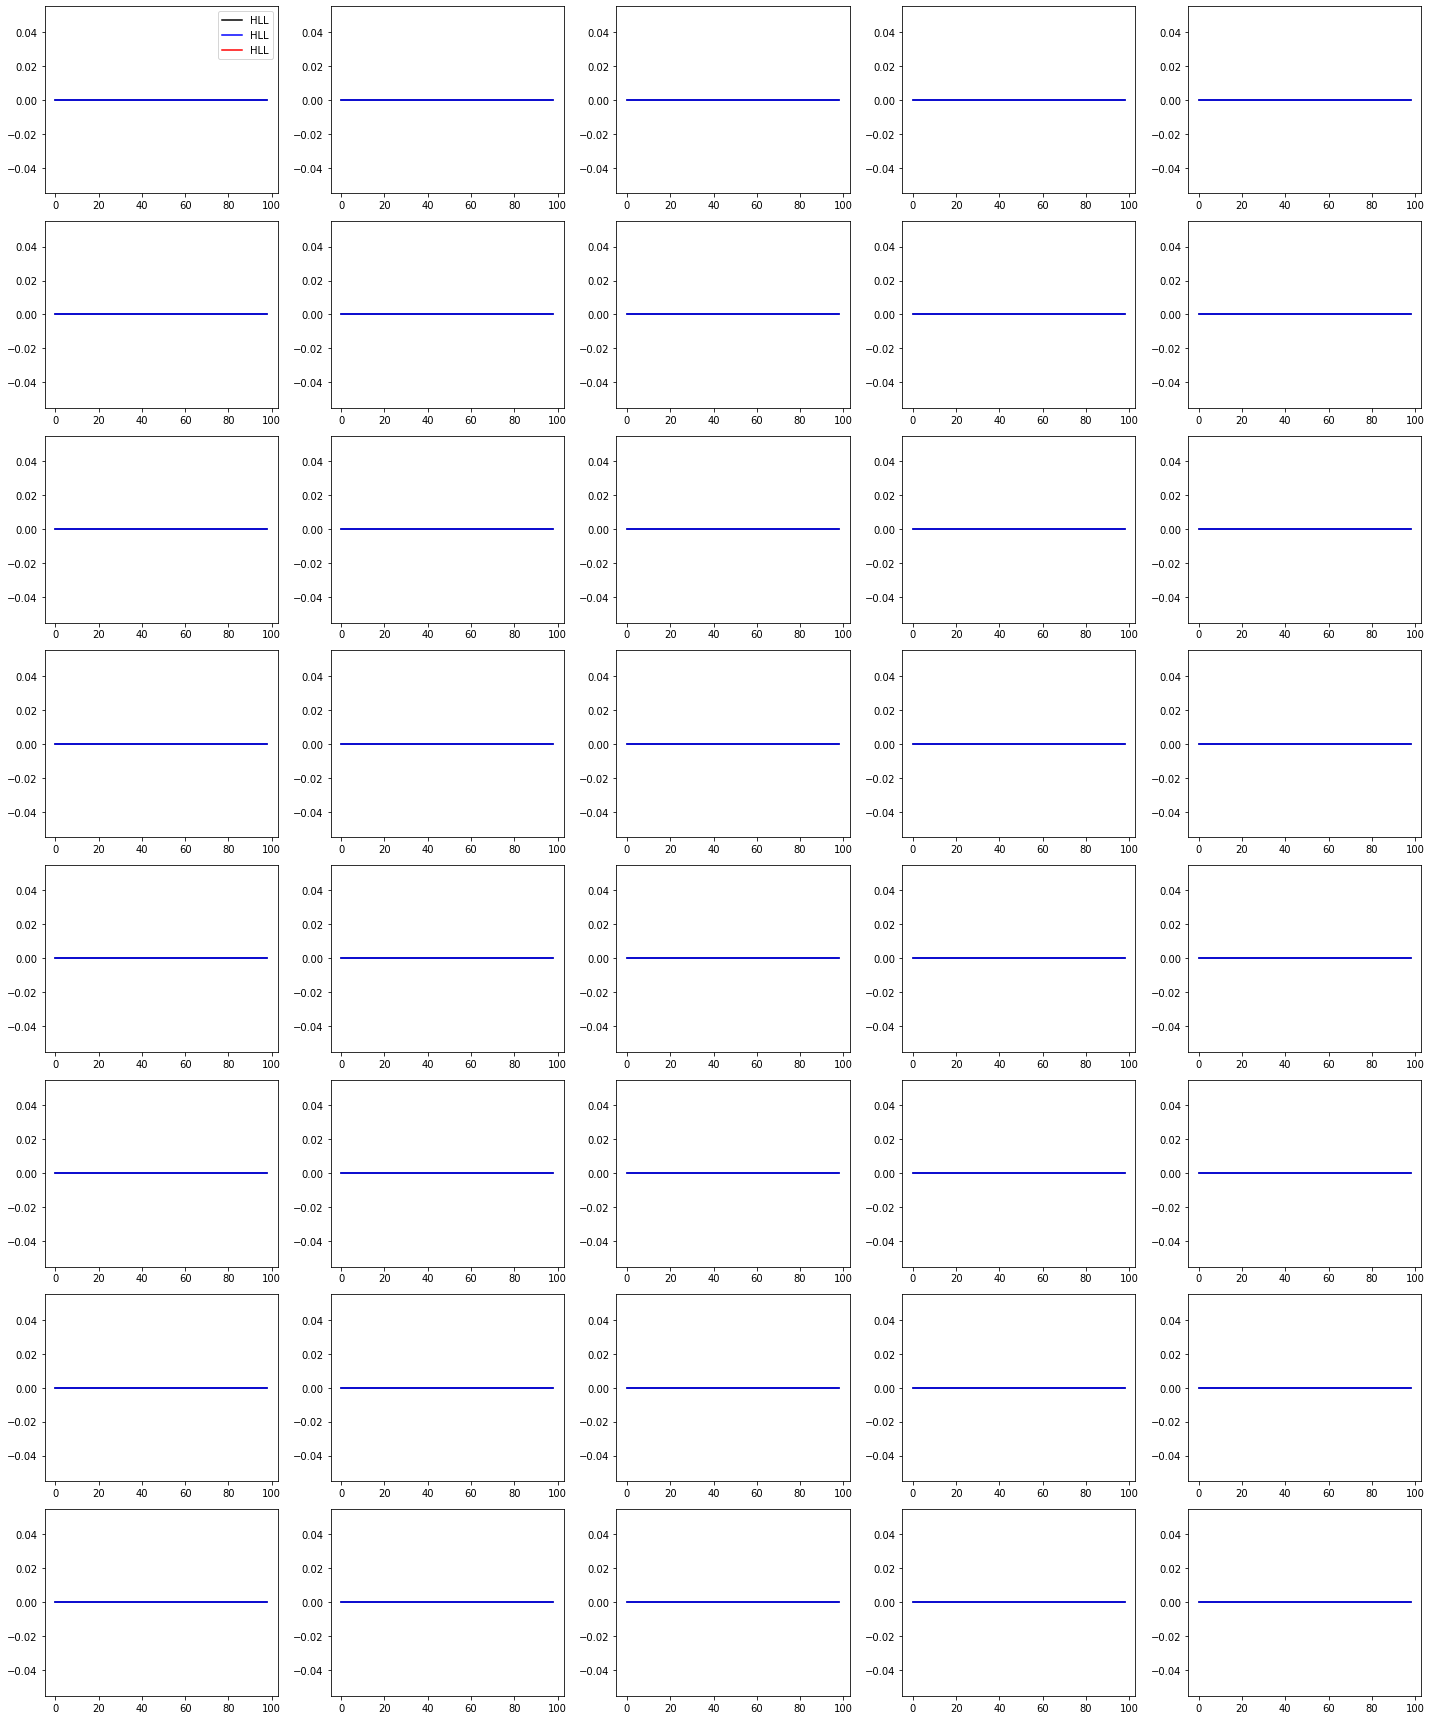

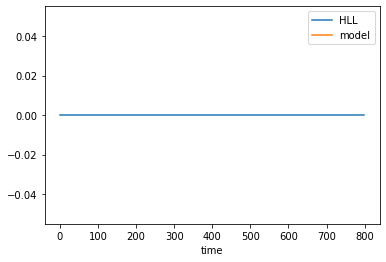

In [15]:
compare_along_the_time(GenParam.kind_changing)

### kind Sod

(1, 600, 3)


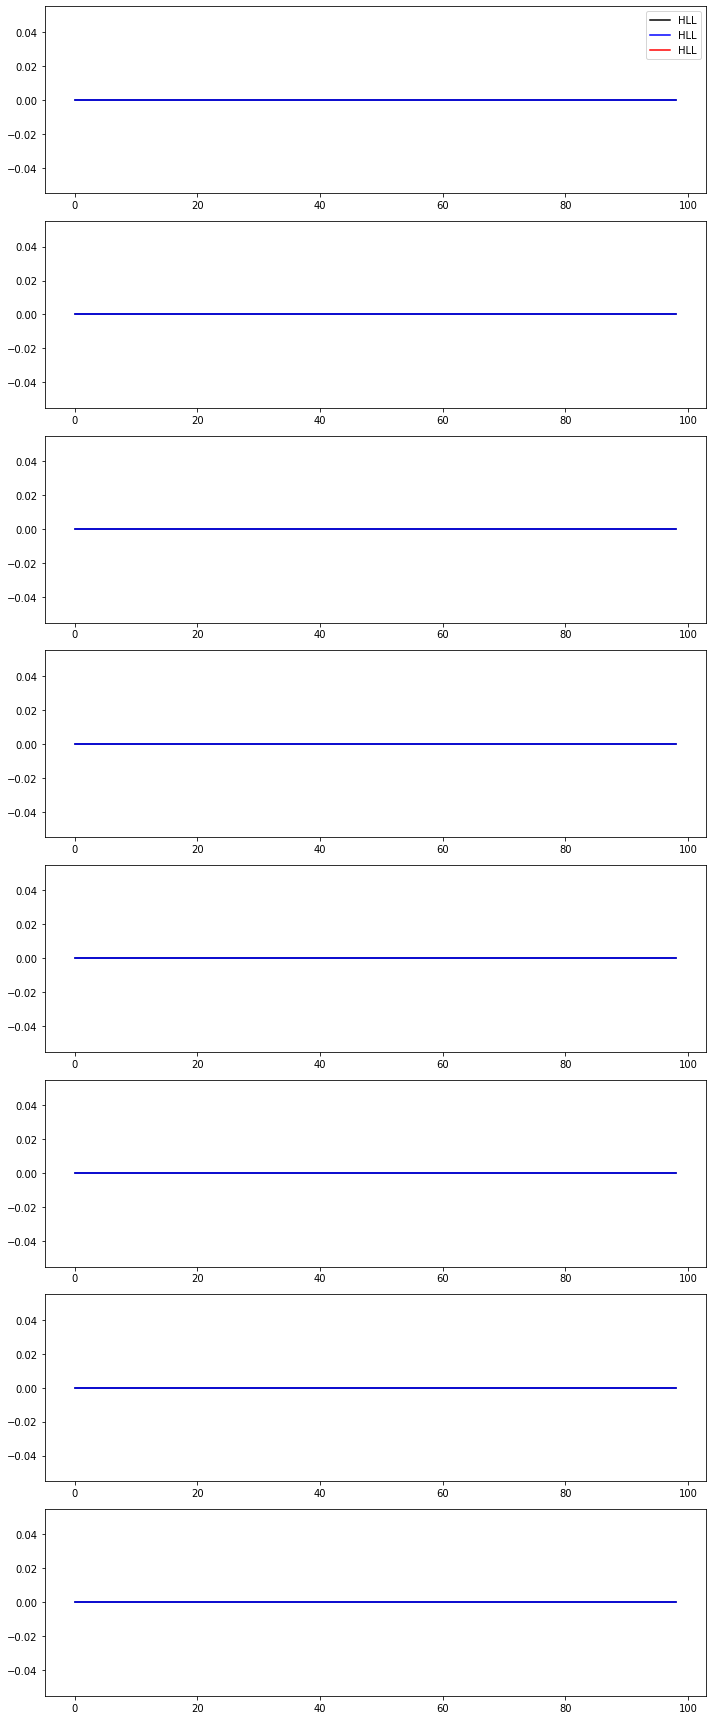

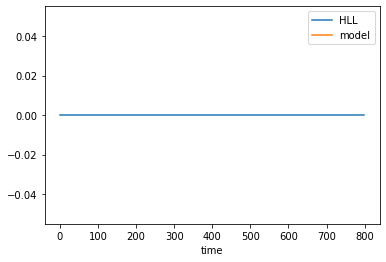

In [16]:
compare_along_the_time(GenParam.kind_sod)

### Kind random Sod

(64, 600, 3)


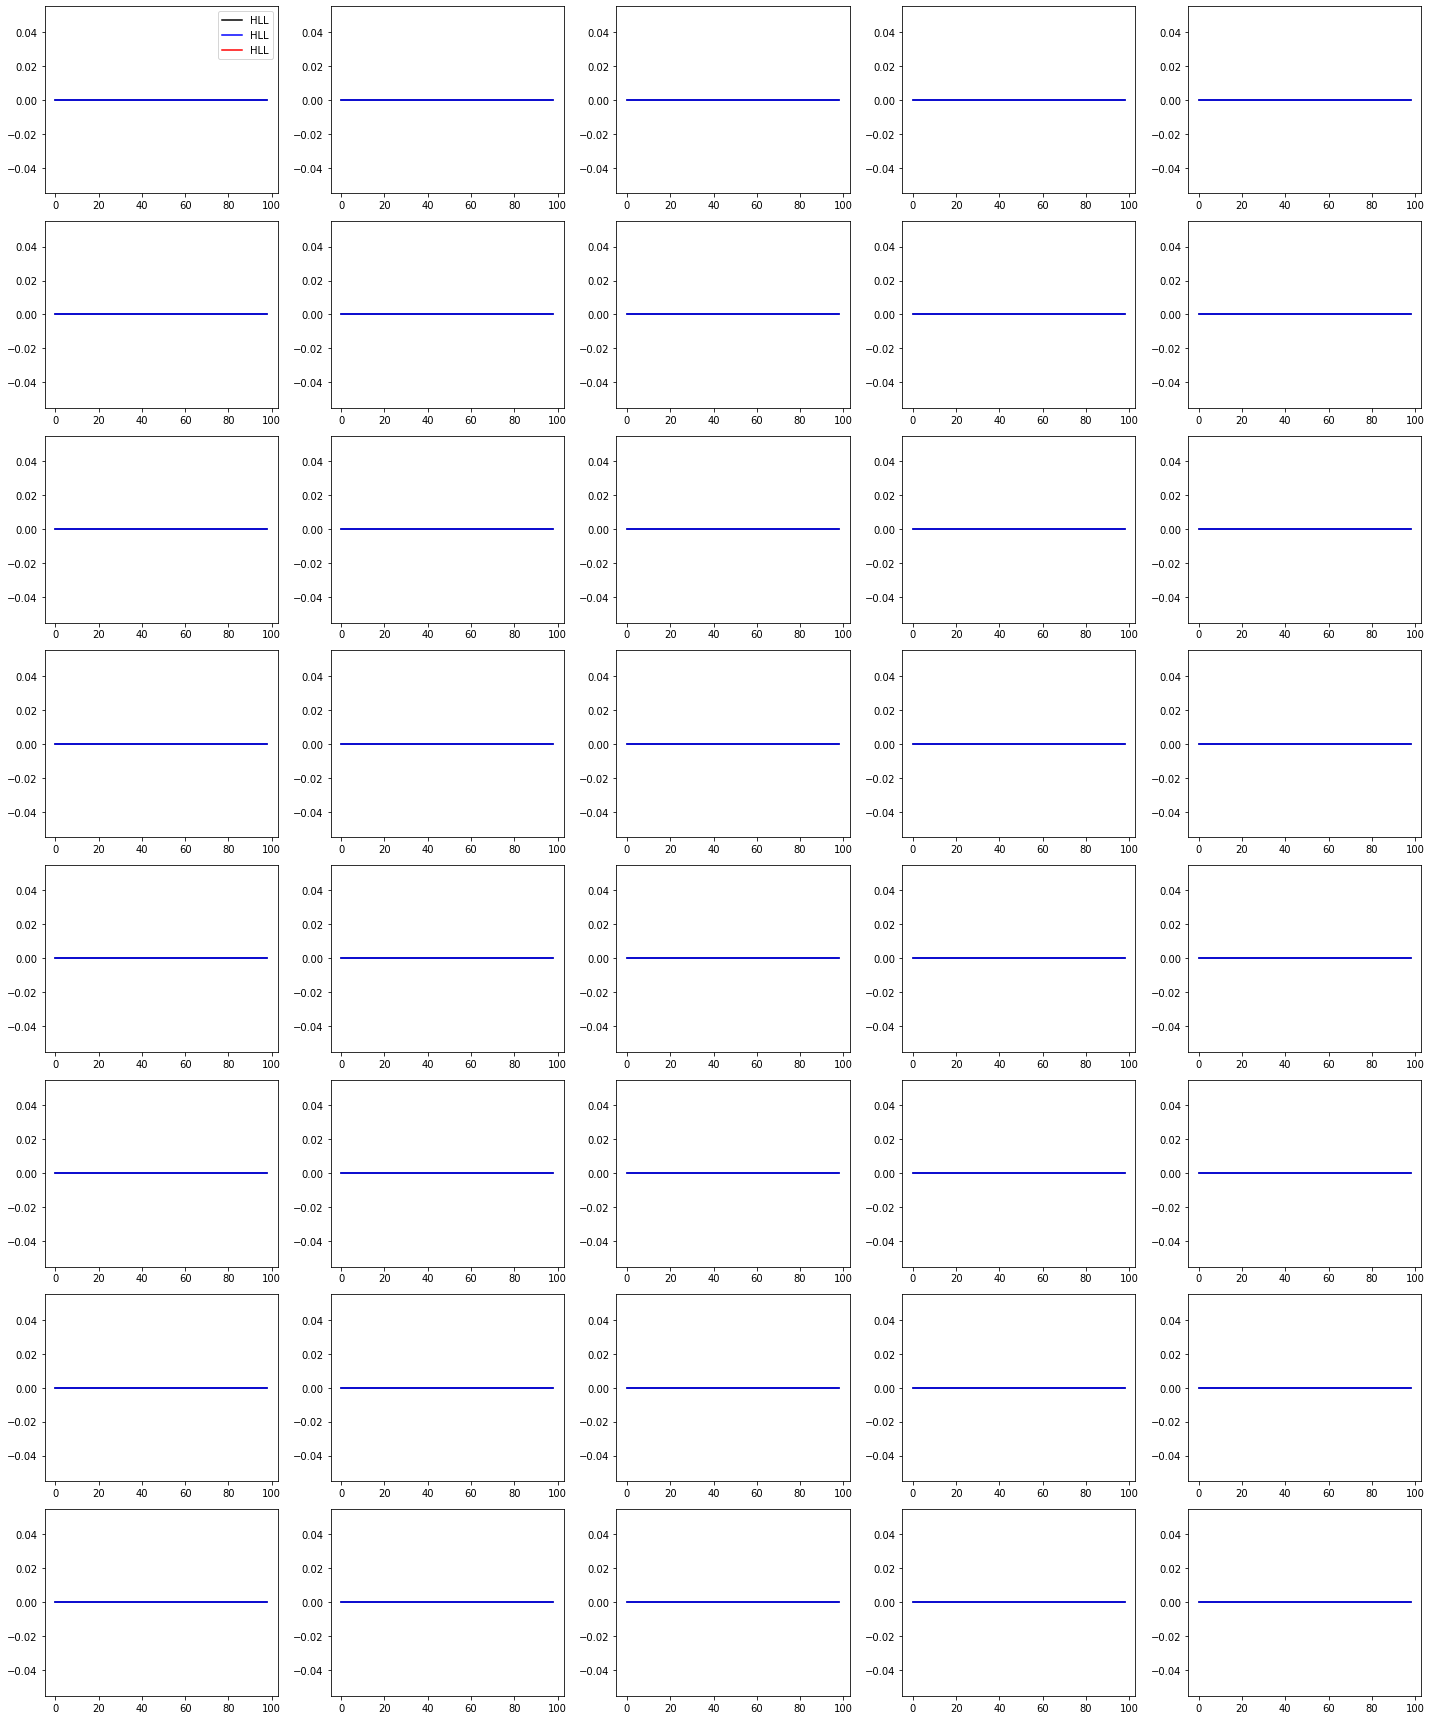

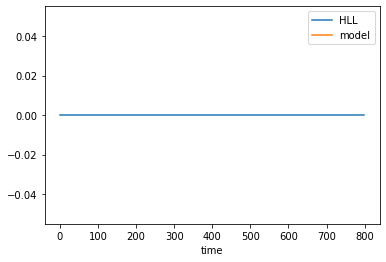

In [17]:
compare_along_the_time(GenParam.kind_random_sod)